In [ ]:
import numpy as np
import pandas as pd
import os

# ----------------------------
# Parameters
# ----------------------------
N_RECORDS = 8000
OUTPUT_PATH = "data/raw/realistic_regulatory_data.csv"

def generate_regulatory_data(n=8000, seed=42):
    np.random.seed(seed)

    # -------------------------------
    # Base reference data
    # -------------------------------
    currencies = ["INR", "USD", "GBP", "EUR", "HKD", "SGD"]
    countries = ["IN", "US", "GB", "DE", "FR", "ES", "IT", "NL", "HK", "SG"]
    counterparties = ["Retail", "Corporate", "Sovereign", "Bank"]
    product_types = ["Loan", "Bond", "Derivative", "Repo"]
    exposure_classes = ["Retail", "Corporate", "Sovereign", "Bank"]

    # -------------------------------
    # Base dataset
    # -------------------------------
    df = pd.DataFrame({
        "Account_ID": np.arange(1, n+1),
        "Report_Date": pd.to_datetime("2025-03-31"),
        "Exposure_Amount": np.random.lognormal(mean=10, sigma=1.0, size=n),
        "Risk_Weight": np.random.uniform(0.1, 1.0, size=n),
        "Country_Code": np.random.choice(countries, size=n),
        "Currency": np.random.choice(currencies, size=n),
        "Counterparty_Type": np.random.choice(counterparties, size=n),
        "Product_Type": np.random.choice(product_types, size=n),
        "Exposure_Class": np.random.choice(exposure_classes, size=n),
        "Credit_Quality_Step": np.random.randint(1, 9, size=n),
        "Maturity_Months": np.random.randint(1, 360, size=n),
        "Is_Collateralized": np.random.choice([0, 1], size=n, p=[0.7, 0.3]),
    })

    # -------------------------------
    # Derived fields
    # -------------------------------
    df["Capital_Requirement"] = df["Exposure_Amount"] * df["Risk_Weight"] * 0.08
    df["RWA"] = df["Exposure_Amount"] * df["Risk_Weight"]
    df["Exposure_to_Capital_Ratio"] = df["Exposure_Amount"] / (df["Capital_Requirement"] + 1)

    # -------------------------------
    # Inject RULE-BASED anomalies
    # -------------------------------
    df["Injected_Rule_Anomaly"] = 0

    # 1) Missing critical fields
    idx_missing = np.random.choice(df.index, size=int(0.03 * n), replace=False)
    df.loc[idx_missing, "Exposure_Amount"] = np.nan
    df.loc[idx_missing, "Injected_Rule_Anomaly"] = 1

    # 2) Invalid currency codes
    idx_invalid_currency = np.random.choice(df.index, size=int(0.02 * n), replace=False)
    df.loc[idx_invalid_currency, "Currency"] = "XXX"
    df.loc[idx_invalid_currency, "Injected_Rule_Anomaly"] = 1

    # 3) Negative exposures
    idx_negative = np.random.choice(df.index, size=int(0.02 * n), replace=False)
    df.loc[idx_negative, "Exposure_Amount"] = -abs(df.loc[idx_negative, "Exposure_Amount"])
    df.loc[idx_negative, "Injected_Rule_Anomaly"] = 1

    # 4) Risk weight out of bounds
    idx_bad_rw = np.random.choice(df.index, size=int(0.02 * n), replace=False)
    df.loc[idx_bad_rw, "Risk_Weight"] = 1.5
    df.loc[idx_bad_rw, "Injected_Rule_Anomaly"] = 1

    # 5) Capital mismatch
    idx_bad_capital = np.random.choice(df.index, size=int(0.02 * n), replace=False)
    df.loc[idx_bad_capital, "Capital_Requirement"] = df.loc[idx_bad_capital, "Capital_Requirement"] * 0.3
    df.loc[idx_bad_capital, "Injected_Rule_Anomaly"] = 1

    # 6) Duplicates
    dup_idx = np.random.choice(df.index, size=int(0.02 * n), replace=False)
    df = pd.concat([df, df.loc[dup_idx]], ignore_index=True)
    df.loc[dup_idx, "Injected_Rule_Anomaly"] = 1

    # -------------------------------
    # Inject ML-ONLY hidden anomalies (IMPORTANT)
    # These DO NOT violate any rule
    # -------------------------------
    df["Injected_ML_Only_Anomaly"] = 0

    clean_idx = df[df["Injected_Rule_Anomaly"] == 0].sample(frac=0.01, random_state=seed).index

    # Strange but valid combinations:
    df.loc[clean_idx, "Exposure_Amount"] = df["Exposure_Amount"].median() * 1.8
    df.loc[clean_idx, "Risk_Weight"] = 0.05   # still valid
    df.loc[clean_idx, "Credit_Quality_Step"] = 1
    df.loc[clean_idx, "Maturity_Months"] = 300
    df.loc[clean_idx, "Is_Collateralized"] = 1
    df.loc[clean_idx, "Product_Type"] = "Derivative"

    # Recalculate derived fields
    df.loc[clean_idx, "Capital_Requirement"] = df.loc[clean_idx, "Exposure_Amount"] * df.loc[clean_idx, "Risk_Weight"] * 0.08
    df.loc[clean_idx, "RWA"] = df.loc[clean_idx, "Exposure_Amount"] * df.loc[clean_idx, "Risk_Weight"]
    df.loc[clean_idx, "Exposure_to_Capital_Ratio"] = df.loc[clean_idx, "Exposure_Amount"] / (df.loc[clean_idx, "Capital_Requirement"] + 1)

    df.loc[clean_idx, "Injected_ML_Only_Anomaly"] = 1

    # -------------------------------
    # Shuffle dataset
    # -------------------------------
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    return df


if __name__ == "__main__":
    df = generate_regulatory_data(n=N_RECORDS)
    os.makedirs("data/raw", exist_ok=True)
    df.to_csv(OUTPUT_PATH, index=False)
    print("Generated dataset shape:", df.shape)
    print("Rule anomalies:", df["Injected_Rule_Anomaly"].sum())
    print("ML-only anomalies:", df["Injected_ML_Only_Anomaly"].sum())

Generated dataset shape: (8160, 17)
Rule anomalies: 996
ML-only anomalies: 72


In [ ]:
import os
import json
import pandas as pd
import numpy as np

# -----------------------------
# Config loading
# -----------------------------
CONFIG_PATH = "dq_config.json"
RAW_DATA_PATH = "data/raw/realistic_regulatory_data.csv"
OUTPUT_PATH = "data/processed/processed_data.csv"

os.makedirs("data/processed", exist_ok=True)

with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(RAW_DATA_PATH)

# -----------------------------
# Initialize rule results
# -----------------------------
df["DQ_RULE_SCORE"] = 0
df["RULE_ANOMALY_FLAG"] = 0

# -----------------------------
# Helper to add rule violation
# -----------------------------
def flag_violation(mask):
    df.loc[mask, "DQ_RULE_SCORE"] += 1

# -----------------------------
# RULE 1: Missing critical fields
# -----------------------------
critical_fields = config.get("critical_fields", [])
for col in critical_fields:
    if col in df.columns:
        flag_violation(df[col].isna())

# -----------------------------
# RULE 2: Invalid currency codes
# -----------------------------
allowed_currencies = config["code_lists"]["allowed_currencies"]
if "Currency" in df.columns:
    flag_violation(~df["Currency"].isin(allowed_currencies))

# -----------------------------
# RULE 3: Invalid country codes
# -----------------------------
allowed_countries = config["code_lists"]["iso_country_subset"]
if "Country_Code" in df.columns:
    flag_violation(~df["Country_Code"].isin(allowed_countries))

# -----------------------------
# RULE 4: Exposure must be >= 0
# -----------------------------
if "Exposure_Amount" in df.columns:
    flag_violation(df["Exposure_Amount"] < 0)

# -----------------------------
# RULE 5: Risk weight bounds
# -----------------------------
rw_min = config["bounds"]["risk_weight_min"]
rw_max = config["bounds"]["risk_weight_max"]
if "Risk_Weight" in df.columns:
    flag_violation((df["Risk_Weight"] < rw_min) | (df["Risk_Weight"] > rw_max))

# -----------------------------
# RULE 6: Tenor bounds (if present)
# -----------------------------
if "Maturity_Months" in df.columns:
    tmin = config["bounds"]["tenor_min_months"]
    tmax = config["bounds"]["tenor_max_months"]
    flag_violation((df["Maturity_Months"] < tmin) | (df["Maturity_Months"] > tmax))

# -----------------------------
# RULE 7: Capital formula consistency
# -----------------------------
if all(col in df.columns for col in ["Exposure_Amount", "Risk_Weight", "Capital_Requirement"]):
    expected_capital = df["Exposure_Amount"] * df["Risk_Weight"] * config["capital_check"]["capital_formula_multiplier"]
    tolerance = config["capital_check"]["capital_tolerance_percentage"]
    diff_ratio = (df["Capital_Requirement"] - expected_capital).abs() / (expected_capital + 1e-6)
    flag_violation(diff_ratio > tolerance)

# -----------------------------
# RULE 8: Duplicate keys
# -----------------------------
dup_keys = config["duplication"]["duplicate_key"]
existing_dup_keys = [k for k in dup_keys if k in df.columns]
if len(existing_dup_keys) > 0:
    dup_mask = df.duplicated(subset=existing_dup_keys, keep=False)
    flag_violation(dup_mask)

# -----------------------------
# Final rule anomaly flag
# -----------------------------
df["RULE_ANOMALY_FLAG"] = (df["DQ_RULE_SCORE"] > 0).astype(int)

# -----------------------------
# Save output
# -----------------------------
df.to_csv(OUTPUT_PATH, index=False)

# -----------------------------
# Summary print
# -----------------------------
print("=== DQ ENGINE SUMMARY ===")
print("Input rows:", len(df))
print("Rows with rule violations:", df["RULE_ANOMALY_FLAG"].sum())
print("Average rule violations per row:", df["DQ_RULE_SCORE"].mean())
print("Output written to:", OUTPUT_PATH)


=== DQ ENGINE SUMMARY ===
Input rows: 8160
Rows with rule violations: 1137
Average rule violations per row: 0.16715686274509803
Output written to: data/processed/processed_data.csv


In [ ]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# Paths
# -----------------------------
INPUT_PATH = "data/processed/processed_data.csv"
OUTPUT_PATH = "data/processed/model_scores_detailed.csv"

os.makedirs("data/processed", exist_ok=True)

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(INPUT_PATH)

# Row identifier
if "Account_ID" in df.columns:
    ids = df["Account_ID"].values
else:
    ids = np.arange(len(df))

# -----------------------------
# Drop non-ML columns
# -----------------------------
DROP_COLS = [
    "Account_ID",
    "Report_Date",
    "Injected_Rule_Anomaly",
    "Injected_ML_Only_Anomaly",
    "DQ_RULE_SCORE",
    "RULE_ANOMALY_FLAG"
]

X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

# -----------------------------
# Identify feature types
# -----------------------------
categorical_cols = X_df.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()

# -----------------------------
# Preprocessing
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ]
)

X = preprocessor.fit_transform(X_df)

# -----------------------------
# Impute missing values
# -----------------------------
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# -----------------------------
# Train models
# -----------------------------

# Isolation Forest
if_model = IsolationForest(contamination=0.05, random_state=42)
if_model.fit(X)
if_scores = -if_model.decision_function(X)

# LOF
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.05)
lof.fit(X)
lof_scores = -lof.decision_function(X)

# OCSVM
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
ocsvm.fit(X)
ocsvm_scores = -ocsvm.decision_function(X)

# PCA
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X)
X_pca_rec = pca.inverse_transform(pca.transform(X))
pca_scores = np.mean((X - X_pca_rec) ** 2, axis=1)

# Autoencoder
input_dim = X.shape[1]
inp = Input(shape=(input_dim,))
x = Dense(64, activation="relu")(inp)
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
out = Dense(input_dim, activation="linear")(x)

ae = Model(inp, out)
ae.compile(optimizer="adam", loss="mse")

ae.fit(
    X, X,
    validation_split=0.1,
    epochs=50,
    batch_size=256,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

ae_scores = np.mean(np.square(ae.predict(X, verbose=0)), axis=1)

# -----------------------------
# Normalize scores
# -----------------------------
def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

score_if = normalize(if_scores)
score_lof = normalize(lof_scores)
score_ocsvm = normalize(ocsvm_scores)
score_pca = normalize(pca_scores)
score_ae = normalize(ae_scores)

# -----------------------------
# Ensemble score
# -----------------------------
ENSEMBLE_SCORE = (
    0.3 * score_if +
    0.1 * score_lof +
    0.1 * score_ocsvm +
    0.2 * score_pca +
    0.3 * score_ae
)

# -----------------------------
# Thresholding
# -----------------------------
threshold = np.quantile(ENSEMBLE_SCORE, 0.95)
ML_ANOMALY_FLAG = (ENSEMBLE_SCORE >= threshold).astype(int)

# -----------------------------
# Save detailed output
# -----------------------------
out_df = pd.DataFrame({
    "ROW_ID": ids,
    "IF_SCORE": score_if,
    "LOF_SCORE": score_lof,
    "OCSVM_SCORE": score_ocsvm,
    "PCA_SCORE": score_pca,
    "AE_SCORE": score_ae,
    "ENSEMBLE_SCORE": ENSEMBLE_SCORE,
    "ML_ANOMALY_FLAG": ML_ANOMALY_FLAG
})

out_df.to_csv(OUTPUT_PATH, index=False)

# -----------------------------
# Summary
# -----------------------------
print("=== MODEL SCORING (DETAILED) SUMMARY ===")
print("Rows:", len(out_df))
print("ML anomalies flagged:", out_df["ML_ANOMALY_FLAG"].sum())
print("Output written to:", OUTPUT_PATH)


=== MODEL SCORING (DETAILED) SUMMARY ===
Rows: 8160
ML anomalies flagged: 408
Output written to: data/processed/model_scores_detailed.csv


In [ ]:
import os
import pandas as pd

# -----------------------------
# Paths
# -----------------------------
RULE_PATH = "data/processed/processed_data.csv"
ML_PATH = "data/processed/model_scores_detailed.csv"
OUTPUT_PATH = "data/processed/final_scored_data.csv"

os.makedirs("data/processed", exist_ok=True)

# -----------------------------
# Load data
# -----------------------------
df_rules = pd.read_csv(RULE_PATH)
df_ml = pd.read_csv(ML_PATH)

# -----------------------------
# Create join key
# -----------------------------
if "Account_ID" in df_rules.columns:
    df_rules["ROW_ID"] = df_rules["Account_ID"]
else:
    df_rules["ROW_ID"] = df_rules.index

# -----------------------------
# Merge
# -----------------------------
df = df_rules.merge(df_ml, on="ROW_ID", how="left")

# Safety fill
df["ENSEMBLE_SCORE"] = df["ENSEMBLE_SCORE"].fillna(0.0)
df["ML_ANOMALY_FLAG"] = df["ML_ANOMALY_FLAG"].fillna(0).astype(int)

# -----------------------------
# Final anomaly decision
# -----------------------------
df["FINAL_ANOMALY_FLAG"] = (
    (df["RULE_ANOMALY_FLAG"] == 1) | (df["ML_ANOMALY_FLAG"] == 1)
).astype(int)

# -----------------------------
# For evaluation compatibility
# -----------------------------
df["ML_SCORE"] = df["ENSEMBLE_SCORE"]

# -----------------------------
# Save
# -----------------------------
df.to_csv(OUTPUT_PATH, index=False)

# -----------------------------
# Summary
# -----------------------------
print("=== UNIFIED SCORING SUMMARY ===")
print("Rows:", len(df))
print("Rule anomalies:", df["RULE_ANOMALY_FLAG"].sum())
print("ML anomalies:", df["ML_ANOMALY_FLAG"].sum())
print("Final anomalies:", df["FINAL_ANOMALY_FLAG"].sum())
print("ML-only anomalies:", ((df["RULE_ANOMALY_FLAG"] == 0) & (df["ML_ANOMALY_FLAG"] == 1)).sum())
print("Output written to:", OUTPUT_PATH)


=== UNIFIED SCORING SUMMARY ===
Rows: 8480
Rule anomalies: 1457
ML anomalies: 424
Final anomalies: 1779
ML-only anomalies: 322
Output written to: data/processed/final_scored_data.csv


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# -----------------------------
# Paths
# -----------------------------
FINAL_PATH = "data/processed/final_scored_data.csv"
ML_DETAIL_PATH = "data/processed/model_scores_detailed.csv"
ARTIFACT_DIR = "artifacts"

os.makedirs(ARTIFACT_DIR, exist_ok=True)

# -----------------------------
# Load data
# -----------------------------
df_final = pd.read_csv(FINAL_PATH)
df_ml = pd.read_csv(ML_DETAIL_PATH)

# -----------------------------
# Ground truth
# -----------------------------
df_final["TRUE_ANOMALY"] = (
    (df_final["Injected_Rule_Anomaly"] == 1) |
    (df_final["Injected_ML_Only_Anomaly"] == 1)
).astype(int)

# -----------------------------
# Helper
# -----------------------------
def precision_at_k(y_true, scores, k=0.05):
    n = int(len(scores) * k)
    idx = np.argsort(scores)[::-1][:n]
    return y_true[idx].mean()

def safe_auc(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except:
        return np.nan

# -----------------------------
# ========== PART 1: ML MODEL COMPARISON ==========
# -----------------------------
ml_eval = df_ml.merge(df_final[["ROW_ID", "TRUE_ANOMALY"]], on="ROW_ID", how="left")

models = {
    "IsolationForest": "IF_SCORE",
    "LOF": "LOF_SCORE",
    "OCSVM": "OCSVM_SCORE",
    "PCA": "PCA_SCORE",
    "Autoencoder": "AE_SCORE",
    "Ensemble": "ENSEMBLE_SCORE"
}

ml_results = []

for name, col in models.items():
    auc = safe_auc(ml_eval["TRUE_ANOMALY"], ml_eval[col])
    p5 = precision_at_k(ml_eval["TRUE_ANOMALY"].values, ml_eval[col].values, k=0.05)
    ml_results.append({
        "Model": name,
        "ROC_AUC": auc,
        "Precision@5%": p5
    })

ml_results_df = pd.DataFrame(ml_results)
ml_results_df.to_csv(os.path.join(ARTIFACT_DIR, "model_comparison_ml.csv"), index=False)

# -----------------------------
# ========== PART 2: SYSTEM COMPARISON ==========
# -----------------------------
system_results = []

system_results.append({
    "System": "Rule-Based",
    "ROC_AUC": safe_auc(df_final["TRUE_ANOMALY"], df_final["RULE_ANOMALY_FLAG"]),
    "Precision@5%": np.nan
})

system_results.append({
    "System": "ML-Based (Ensemble)",
    "ROC_AUC": safe_auc(df_final["TRUE_ANOMALY"], df_final["ML_SCORE"]),
    "Precision@5%": precision_at_k(df_final["TRUE_ANOMALY"].values, df_final["ML_SCORE"].values, k=0.05)
})

system_results.append({
    "System": "Hybrid (Rule + ML)",
    "ROC_AUC": safe_auc(df_final["TRUE_ANOMALY"], df_final["FINAL_ANOMALY_FLAG"]),
    "Precision@5%": np.nan
})

system_df = pd.DataFrame(system_results)
system_df.to_csv(os.path.join(ARTIFACT_DIR, "model_comparison_system.csv"), index=False)

# -----------------------------
# ========== PART 3: OVERLAP ANALYSIS ==========
# -----------------------------
rule_only = ((df_final["RULE_ANOMALY_FLAG"] == 1) & (df_final["ML_ANOMALY_FLAG"] == 0)).sum()
ml_only = ((df_final["RULE_ANOMALY_FLAG"] == 0) & (df_final["ML_ANOMALY_FLAG"] == 1)).sum()
both = ((df_final["RULE_ANOMALY_FLAG"] == 1) & (df_final["ML_ANOMALY_FLAG"] == 1)).sum()

with open(os.path.join(ARTIFACT_DIR, "overlap_analysis.txt"), "w") as f:
    f.write("=== OVERLAP ANALYSIS ===\n")
    f.write(f"Total rows: {len(df_final)}\n")
    f.write(f"True anomalies: {df_final['TRUE_ANOMALY'].sum()}\n")
    f.write(f"Rule-only anomalies: {rule_only}\n")
    f.write(f"ML-only anomalies: {ml_only}\n")
    f.write(f"Detected by both: {both}\n")
    f.write(f"Final anomalies: {df_final['FINAL_ANOMALY_FLAG'].sum()}\n")

# -----------------------------
# Print summary
# -----------------------------
print("=== ML MODEL COMPARISON ===")
print(ml_results_df)
print()

print("=== SYSTEM COMPARISON ===")
print(system_df)
print()

print("=== OVERLAP ===")
print("Rule-only:", rule_only)
print("ML-only:", ml_only)
print("Both:", both)

print()
print("Artifacts written to:", ARTIFACT_DIR)


=== ML MODEL COMPARISON ===
             Model   ROC_AUC  Precision@5%
0  IsolationForest  0.595768      0.339912
1              LOF  0.586153      0.614035
2            OCSVM  0.604967      0.482456
3              PCA  0.574871      0.561404
4      Autoencoder  0.573841      0.353070
5         Ensemble  0.609705      0.396930

=== SYSTEM COMPARISON ===
                System   ROC_AUC  Precision@5%
0           Rule-Based  0.951637           NaN
1  ML-Based (Ensemble)  0.633439         0.375
2   Hybrid (Rule + ML)  0.960874           NaN

=== OVERLAP ===
Rule-only: 1355
ML-only: 322
Both: 102

Artifacts written to: artifacts


Using features for IF SHAP: ['Exposure_Amount', 'Risk_Weight', 'Credit_Quality_Step', 'Maturity_Months', 'Is_Collateralized', 'Capital_Requirement', 'RWA', 'Exposure_to_Capital_Ratio']
=== IF SHAP DONE ===
Saved:
 - artifacts/shap_if_feature_importance.csv
 - artifacts/shap_if_summary.png


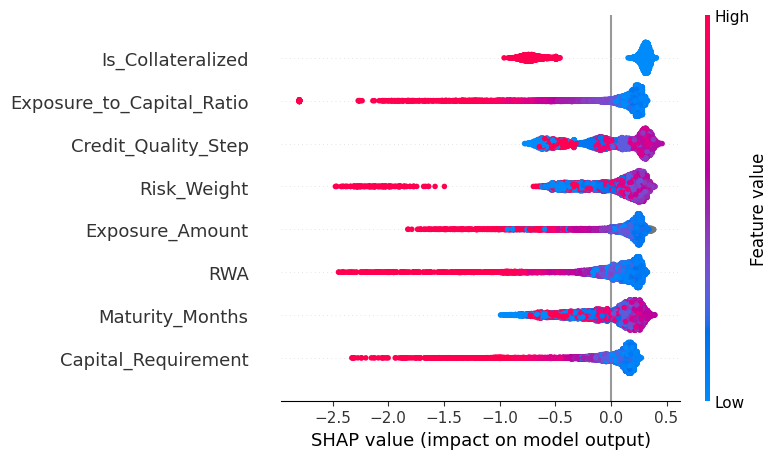

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import os

# -----------------------------
# Paths
# -----------------------------
DATA_PATH = "data/processed/final_scored_data.csv"
ARTIFACT_DIR = "artifacts"

os.makedirs(ARTIFACT_DIR, exist_ok=True)

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(DATA_PATH)

# -----------------------------
# Clean feature selection
# -----------------------------
DROP_COLS = [
    # Identifiers
    "Account_ID", "ROW_ID", "Report_Date",

    # Labels / flags
    "Injected_Rule_Anomaly", "Injected_ML_Only_Anomaly",
    "DQ_RULE_SCORE", "RULE_ANOMALY_FLAG",
    "ML_ANOMALY_FLAG", "FINAL_ANOMALY_FLAG",

    # Model outputs
    "IF_SCORE", "LOF_SCORE", "OCSVM_SCORE", "PCA_SCORE", "AE_SCORE",
    "ENSEMBLE_SCORE", "ML_SCORE"
]

features = [c for c in df.columns if c not in DROP_COLS]

X = df[features].copy()

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

print("Using features for IF SHAP:", X.columns.tolist())

# -----------------------------
# Scale
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Train Isolation Forest
# -----------------------------
if_model = IsolationForest(contamination=0.05, random_state=42)
if_model.fit(X_scaled)

# -----------------------------
# SHAP
# -----------------------------
explainer = shap.TreeExplainer(if_model)
shap_values = explainer.shap_values(X_scaled)

# -----------------------------
# Global importance
# -----------------------------
mean_abs = np.abs(shap_values).mean(axis=0)

imp_df = pd.DataFrame({
    "Feature": X.columns,
    "MeanAbsSHAP": mean_abs
}).sort_values("MeanAbsSHAP", ascending=False)

# Save CSV
imp_df.to_csv(os.path.join(ARTIFACT_DIR, "shap_if_feature_importance.csv"), index=False)

# Plot
plt.figure()
shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "shap_if_summary.png"), dpi=150)

print("=== IF SHAP DONE ===")
print("Saved:")
print(" - artifacts/shap_if_feature_importance.csv")
print(" - artifacts/shap_if_summary.png")


Using features for AE SHAP: ['Exposure_Amount', 'Risk_Weight', 'Credit_Quality_Step', 'Maturity_Months', 'Is_Collateralized', 'Capital_Requirement', 'RWA', 'Exposure_to_Capital_Ratio']
Rows used for AE SHAP: 600
=== AE SURROGATE SHAP DONE ===
Saved:
 - artifacts/shap_ae_feature_importance.csv
 - artifacts/shap_ae_summary.png


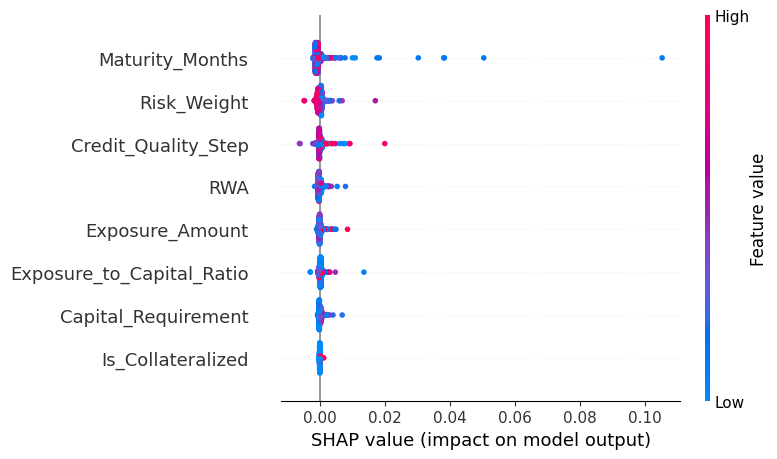

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import os

# -----------------------------
# Paths
# -----------------------------
FINAL_PATH = "data/processed/final_scored_data.csv"
ML_PATH = "data/processed/model_scores_detailed.csv"
ARTIFACT_DIR = "artifacts"

os.makedirs(ARTIFACT_DIR, exist_ok=True)

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(FINAL_PATH)
scores = pd.read_csv(ML_PATH)

# -----------------------------
# Clean feature selection
# -----------------------------
DROP_COLS = [
    # Identifiers
    "Account_ID", "ROW_ID", "Report_Date",

    # Labels / flags
    "Injected_Rule_Anomaly", "Injected_ML_Only_Anomaly",
    "DQ_RULE_SCORE", "RULE_ANOMALY_FLAG",
    "ML_ANOMALY_FLAG", "FINAL_ANOMALY_FLAG",

    # Model outputs
    "IF_SCORE", "LOF_SCORE", "OCSVM_SCORE", "PCA_SCORE", "AE_SCORE",
    "ENSEMBLE_SCORE", "ML_SCORE"
]

features = [c for c in df.columns if c not in DROP_COLS]

X = df[features].copy()
X = X.select_dtypes(include=[np.number])

print("Using features for AE SHAP:", X.columns.tolist())

# -----------------------------
# Target = Autoencoder score
# -----------------------------
y = scores["AE_SCORE"].values

# Align lengths
min_len = min(len(X), len(y))
X = X.iloc[:min_len]
y = y[:min_len]

# -----------------------------
# Scale
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# SUBSAMPLE FOR SPEED
# -----------------------------
MAX_SHAP_ROWS = 600

if X_scaled.shape[0] > MAX_SHAP_ROWS:
    rng = np.random.RandomState(42)
    idx = rng.choice(X_scaled.shape[0], MAX_SHAP_ROWS, replace=False)
    X_shap = X_scaled[idx]
    y_shap = y[idx]
    X_shap_df = X.iloc[idx]
else:
    X_shap = X_scaled
    y_shap = y
    X_shap_df = X.copy()

print("Rows used for AE SHAP:", X_shap.shape[0])

# -----------------------------
# Train surrogate model
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_shap, y_shap)

# -----------------------------
# SHAP
# -----------------------------
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap)

# -----------------------------
# Global importance
# -----------------------------
mean_abs = np.abs(shap_values).mean(axis=0)

imp_df = pd.DataFrame({
    "Feature": X.columns,
    "MeanAbsSHAP": mean_abs
}).sort_values("MeanAbsSHAP", ascending=False)

# Save CSV
imp_df.to_csv(os.path.join(ARTIFACT_DIR, "shap_ae_feature_importance.csv"), index=False)

# Plot
plt.figure()
shap.summary_plot(shap_values, X_shap_df, show=False)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "shap_ae_summary.png"), dpi=150)

print("=== AE SURROGATE SHAP DONE ===")
print("Saved:")
print(" - artifacts/shap_ae_feature_importance.csv")
print(" - artifacts/shap_ae_summary.png")


In [ ]:
!pip install shap